In [ ]:
import tensorflow as tf
print(tf.__version__)
!python --version

2.8.0
Python 3.7.12


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/weather

/content/gdrive/MyDrive/weather


In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/weather'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/MyDrive/weather/weatherAUS.csv


In [ ]:
data=pd.read_csv('/content/gdrive/MyDrive/weather/weatherAUS.csv')

data.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
131744,2014-04-30,Launceston,6.0,15.8,30.4,NaN,NaN,SSE,22.0,ESE,...,42.0,1014.5,1015.1,NaN,NaN,6.7,15.4,Yes,0.0,No
7570,2013-09-23,Cobar,17.7,32.2,0.0,25.2,NaN,NW,48.0,NNW,...,4.0,1010.8,1006.7,0.0,7.0,25.7,30.7,No,0.0,No
125868,2015-03-17,Walpole,18.0,24.8,1.2,NaN,NaN,NW,54.0,NW,...,70.0,1005.2,1002.7,NaN,NaN,21.4,23.7,Yes,8.2,Yes
38301,2015-12-27,WaggaWagga,10.4,25.6,11.2,3.8,13.9,SSW,35.0,S,...,23.0,1017.2,1017.1,0.0,1.0,17.2,24.0,Yes,0.0,No
138981,2017-02-13,Darwin,23.6,29.9,14.6,1.8,2.8,WNW,61.0,W,...,71.0,1008.2,1006.5,8.0,7.0,26.7,29.4,Yes,5.8,Yes


In [ ]:
data['Date']=pd.to_datetime(data['Date'])

data.Date.sample(5)

108871   2017-02-25
69647    2013-04-06
51091    2009-11-01
93779    2017-04-09
110803   2014-04-25
Name: Date, dtype: datetime64[ns]

In [ ]:
data.iloc[:,6].isna().sum()

67816

In [ ]:
import datetime as dt
data['month']=pd.to_datetime(data.Date).dt.to_period('M')

data.month.value_counts()

2016-08    1515
2016-07    1511
2016-05    1506
2017-05    1501
2013-12    1500
           ... 
2008-06      60
2008-02      58
2007-12      31
2008-01      31
2007-11      30
Freq: M, Name: month, Length: 113, dtype: int64

In [ ]:
aa=data.iloc[:,6].name
ac=data.groupby(by='month')[aa].mean()
ab=data['WindSpeed3pm'].isna()
data.loc[ab,['WindSpeed3pm']]=data.loc[ab,'month'].apply(lambda x:ac[x])
data['WindSpeed3pm'].isna().sum()

0

In [ ]:
new_df=pd.DataFrame(list(data['WindSpeed3pm']),index=data.Date,columns=['WindSpeed3pm'])


In [ ]:
new_df=new_df.resample('D').mean()

In [ ]:
from keras.layers import Bidirectional,LSTM,Dense,Flatten,Conv1D,MaxPooling1D,Dropout,RepeatVector
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='loss',patience=5)

In [ ]:
model=Sequential([Conv1D(100,kernel_size=3,input_shape=(30,1),activation='relu'),
                  Conv1D(100,kernel_size=3),
                  Conv1D(100,kernel_size=3),
                  MaxPooling1D(2),
                 Flatten(),
                  RepeatVector(30),
                 LSTM(128,activation='relu',return_sequences=True),
                 LSTM(128,activation='relu',return_sequences=True),
                  Bidirectional(LSTM(64,activation='relu')),
                 Dense(128,activation='relu'),
                 Dense(1)])

model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
new_df1=pd.DataFrame(list(data['WindSpeed3pm']), index=data['Date'], columns=['WindSpeed3pm'])

In [ ]:
new_df1=new_df1.resample('D').mean()
new_df1.WindSpeed3pm.isna().sum()

89

In [ ]:
new_df1.fillna(data['WindSpeed3pm'].mean(),inplace=True)
new_df1.WindSpeed3pm.isna().sum()

0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(-1,1))

In [ ]:
scaled_data=scaler.fit_transform(new_df1)
scaled_data[:5]

array([[-0.27272727],
       [-0.40909091],
       [-0.90909091],
       [-0.09090909],
       [ 0.09090909]])

In [ ]:
steps=30
inp1=[]
out1=[]

for i in range(len(scaled_data)-steps):
    inp1.append(scaled_data[i:i+steps])
    out1.append(scaled_data[i+steps])

In [ ]:
inp1=np.asanyarray(inp1)
out1=np.asanyarray(out1)
x_train1=inp1[:500,:,:]
x_test1=inp1[500:,:,:]
y_train1=out1[:500]
y_test1=out1[500:]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [ ]:
model.fit(x_train1,y_train1,epochs=500)

Epoch 1/500
16/16 [==============================] - 9s 236ms/step - loss: 0.0821 - accuracy: 0.0100
Epoch 2/500
16/16 [==============================] - 4s 236ms/step - loss: 0.0516 - accuracy: 0.0100
Epoch 3/500
16/16 [==============================] - 4s 230ms/step - loss: 0.0509 - accuracy: 0.0100
Epoch 4/500
16/16 [==============================] - 4s 236ms/step - loss: 0.0469 - accuracy: 0.0100
Epoch 5/500
16/16 [==============================] - 5s 277ms/step - loss: 0.0447 - accuracy: 0.0100
Epoch 6/500
16/16 [==============================] - 4s 230ms/step - loss: 0.0477 - accuracy: 0.0100
Epoch 7/500
16/16 [==============================] - 4s 231ms/step - loss: 0.0407 - accuracy: 0.0100
Epoch 8/500
16/16 [==============================] - 4s 239ms/step - loss: 0.0450 - accuracy: 0.0100
Epoch 9/500
16/16 [==============================] - 4s 259ms/step - loss: 0.0440 - accuracy: 0.0100
Epoch 10/500
16/16 [==============================] - 4s 243ms/step - loss: 0.0381 - accura

In [ ]:
predicted=model.predict(x_test1)

In [ ]:
predicted1=scaler.inverse_transform(predicted)

In [ ]:
y_test2=scaler.inverse_transform(y_test1)

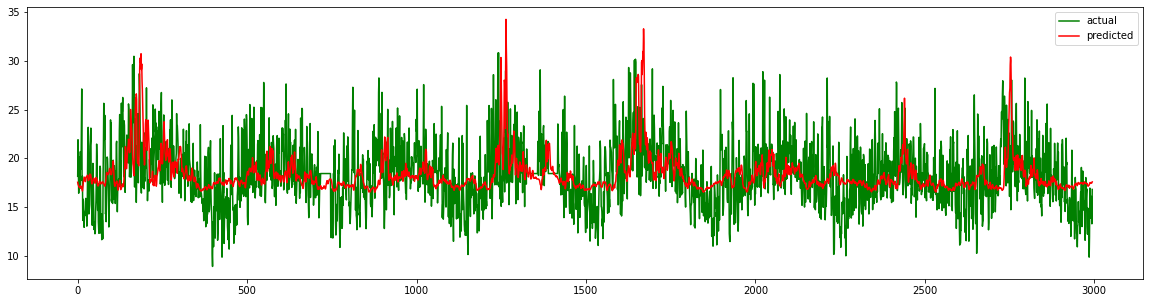

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(y_test2,'g',label='actual')
plt.plot(predicted1,'r',label='predicted')

plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save("/content/gdrive/MyDrive/Weather Forecast Dataset/LSTM_model.h5")